In [1]:
from transformers import pipeline, set_seed

### Hugging face tutorial

In [2]:
generator = pipeline('text-generation', model='gpt2')

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
generator(txt, max_length=100)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'as he drove toward town he thought of nothing except a large order of drills he was hoping to get that day started and that night we got back in the car. But he couldn\'t get it done. He sat there on the ground, for all his senses, in the back seat of the car. Looking back, he says,\n\n"My father never told me his plan was to blow up. I know now I know what he told me."\n\nSo while I was waiting for'}]

In [3]:
generator??

### fastai experiment

In [1]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import torch
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [2]:
text = 'Tripping on hallucinogenics'
encoded_input = tokenizer.encode(text)
encoded_input

[14824, 2105, 319, 23251, 259, 6644, 873]

In [3]:
tokenizer.decode(encoded_input)

'Tripping on hallucinogenics'

In [4]:
t1 = torch.LongTensor(encoded_input)[None]
preds = model.generate(t1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [5]:
preds

tensor([[14824,  2105,   319, 23251,   259,  6644,   873,   318,   257,  2219,
          3357,   287,   262,  1578,  1829,    13,   198,   198,   464,  2563]])

In [6]:
tokenizer.decode(preds[0])

'Tripping on hallucinogenics is a common practice in the United States.\n\nThe drug'

### integrate with fastai

In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(
            self.tokenizer.convert_tokens_to_ids(toks)
        )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))

- in encodes we don't use the tokenizer.encode method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in decodes we return a TitledStr object and not just a plain string. That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.

## 03-16

In [1]:
from fastai.text.all import *
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel,GPT2PreTrainedModel
import re
import codecs
import chardet

In [30]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [3]:
path1 = Path('../data/harrypotter')
path2 = Path('../data/got')

In [4]:
def keep_txt(pths):
    return [p for p in pths if p.suffix == '.txt']
file_pths1 = [
        *path1.ls(file_type='txt').sorted(),
]
file_pths1 = keep_txt(file_pths1)
file_pths2 = keep_txt(path2.ls(file_type='txt').sorted())
file_pths1,file_pths2

([Path('../data/harrypotter/hp1.txt'),
  Path('../data/harrypotter/hp2.txt'),
  Path('../data/harrypotter/hp3.txt'),
  Path('../data/harrypotter/hp4.txt'),
  Path('../data/harrypotter/hp5.txt'),
  Path('../data/harrypotter/hp6.txt'),
  Path('../data/harrypotter/hp7.txt')],
 [Path('../data/got/GOT1.txt'),
  Path('../data/got/GOT1_old.txt'),
  Path('../data/got/GOT2.txt'),
  Path('../data/got/GOT2_old.txt'),
  Path('../data/got/GOT3.txt'),
  Path('../data/got/GOT3_old.txt'),
  Path('../data/got/GOT4.txt'),
  Path('../data/got/GOT5.txt')])

In [5]:
def detect_encoding(pth):
    '''
        resp: {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}
    '''
    with open(pth,'rb') as f:
        c = chardet.detect(f.read())
#         if c['encoding'] != 'utf-8':
        return c

def read_text_in_file(pth,detect_enco=False):
    arr = []
    encoding = detect_encoding(pth)['encoding'] if detect_enco else 'utf-8'
    with open(pth,encoding=encoding) as f:
        line = f.readline()
        while(line):
            arr+=[line]
            line = f.readline()
    return arr

def to_utf8(pth,origin_encoding):
    if origin_encoding == 'utf-8':
        return
    
    o_pth = pth
    
    with open(pth, 'r', encoding=origin_encoding) as f:
        txt = f.read()
    new_pth = pth.rename(
        pth.parent
        /(pth.name.replace(pth.suffix,'')+'_old'+pth.suffix)
    )
    with open(o_pth, 'w', encoding='utf-8') as f:
        f.write(txt)
        
def re_encode(pths):
    for pth in pths:
        c = detect_encoding(pth)
        if c['encoding'] != 'utf-8':
            to_utf8(pth, c['encoding'])
            print(pth,c['encoding'],'DONE')

In [6]:
# def _find_page_in_line(txt):
#     res = re.findall(r'.+(Page\s\d{1,}).+',txt)
#     return len(res) > 0
def clean_text_data(book):
    book = [t for t in book if len(t.strip()) > 0]
#     book = [t for t in book if not _find_page_in_line(t)]
    return book

def count_n_of_txt(arr):
    c = 0
    for t in arr:
        c += len(t.strip())
    return c

In [7]:
books1 = [read_text_in_file(pth) for pth in file_pths1]
books1 = [clean_text_data(b) for b in books1]
#special procession
books1[4] = [l.strip() for l in books1[4]]

books2 = [read_text_in_file(pth) for pth in file_pths2]
books2 = [clean_text_data(b) for b in books2]
books2[4] = [l.strip() for l in books2[4]]

In [8]:
[count_n_of_txt(b) for b in books1],[count_n_of_txt(b) for b in books2]

([434129, 484354, 618222, 1100404, 1478532, 979007, 1120173],
 [1578041, 1578041, 1748586, 1748586, 2273832, 2273832, 1652800, 2297496])

In [9]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
#     def encodes(self, x):
#         toks = self.tokenizer.tokenize(x)
#         return tensor(
#             self.tokenizer.convert_tokens_to_ids(toks)
#         )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))


class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [10]:
def split_data(data,pct=0.9):
    res = []
    res2 = []
    for o in data:
        stop_idx = int(len(o)*0.9)
        res.append(o[:stop_idx])
        res2.append(o[stop_idx:])
    split_idx = len(sum(res,[]))
    flatten_res = sum(res+res2,[])
    return flatten_res, [range(0,split_idx), range(split_idx, len(flatten_res))]

In [11]:
# choose valid data from each book
data,splits = split_data(books2,0.9)

In [11]:
# choose valid data from last book
def split_data2(data1,data2, pct=0.9):
    flatten1 = sum(data1, [])
    flatten2 = sum(data2,[])
    train = []
    valid = []
    stop1 = int(len(flatten1)*0.9)
    stop2 = int(len(flatten2)*0.9)
    train += flatten1[:stop1]
    valid += flatten1[stop1:]
    train += flatten2[:stop2]
    valid += flatten2[stop2:]
    res = train + valid
    splits = [range(0, len(train)), range(len(train), len(res))]
    return res,splits 

In [36]:
#combined data
data, splits = split_data2(books1,books2)
len(data), splits

(101707, [range(0, 91535), range(91535, 101707)])

In [12]:
#got
data, splits = split_data2(books2,[])
len(data), splits

(90145, [range(0, 81130), range(81130, 90145)])

In [13]:
tokenized = [tokenize(t) for t in data]
tls = TfmdLists(data, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=8,seq_len=512)

In [14]:
x,y = dls.train.one_batch()

In [15]:
tokenizer.decode(x[0])

'"The honor is mine." The merchant rummaged about in the back of his stall and produced a small oaken cask. Burned into the wood was a cluster of grapes. "The Redwyne sigil," he said, pointing, "for the Arbor. There is no finer drink."\nrise and fall of her oars as she beat for the Titan and the open sea. "Well,"\nLannister to die alone. Such a man deserves a retinue to attend his needs in\n"What\'s that awful stink?" the northman complained.\nAs Lord Slynt took his place, Grand Maester Pycelle resumed. "Lastly, in these times of treason and turmoil, with our beloved Robert so lately dead, it is the view of the council that the life and safety of King Joffrey is of paramount importance He looked to the queen.\n"And you without an army." Littlefinger toyed with the dagger on the table, turning it slowly with a finger. "There is small love lost between Lord Renly and the Lannisters. Bronze Yohn Royce, Ser Balon Swann, Ser Loras, Lady Tanda, the Redwyne twins... each of them has a retinue

In [31]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()

In [32]:
learn.validate()

(#3) [3.665107250213623,0.3426211178302765,39.060325622558594]

In [18]:
learn = learn.load('04-28-got-gpt2-acc39_1-perp24_6')

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

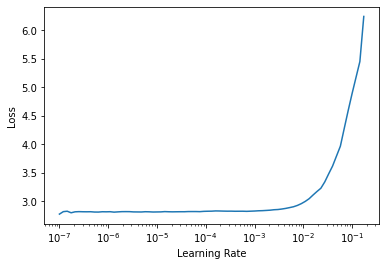

In [20]:
learn.lr_find()

In [21]:
t1 = torch.zeros(100,20)

In [27]:
t1[:, 1::2].shape

torch.Size([100, 10])

In [48]:
t1 = torch.tensor([1,2,3])

In [53]:
t1.unsqueeze(1).shape

torch.Size([3, 1])

In [ ]:
learn.fit_one_cycle(3,3e-4)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

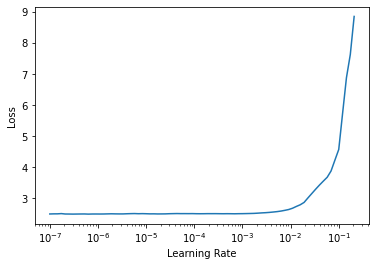

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.517299,3.267373,0.390315,26.242311,03:53


In [15]:
learn.save('./04-28-got-gpt2-acc39_1-perp24_6')

Path('models/04-28-got-gpt2-acc39_1-perp24_6.pth')

In [168]:
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 2304      
Conv1D                                    1771776    True      
Conv1D                                    590592     True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 3072      
Conv1D                                    23623

In [64]:
learn.model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

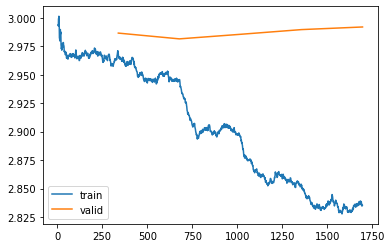

In [22]:
learn.recorder.plot_loss()

In [48]:
modelc = model.cpu()

In [16]:
txt = 'A scream echoed through the forest night, and the longsword'
ids = tokenizer.encode(txt)
inp = tensor(ids)[None].cuda()
beam_search_and_ngram = {
    'num_beams':5,
    #'num_return_sequences':5, # <=beams
    'no_repeat_ngram_size':2,
    
}
top_k_sampling = {
    'do_sample':True,
    'top_k':50
}

top_p = {
    'do_sample':True,
    'top_p': 0.92,
    'top_k': 50
}
preds = model.generate(inp, max_length=100,
                        pad_token_id=tokenizer.eos_token_id,
                    #     repetition_penalty=1.5,
                        temperature=.7,
                        early_stopping=True,
                        **top_p
                                                )
print(preds.shape)

torch.Size([1, 100])


In [17]:
tokenizer.decode(preds[0].cpu(),skip_special_tokens=True)

'A scream echoed through the forest night, and the longsword was coming down. Jon heard a deep rumble, and saw the hand of the direwolf howling. He could feel the steel on his face, the cold dark breath that filled his ears. He was blind from the fear.\n"I never knew you\'d come," he said. "You always said so, did you?"\n"No," said the old woman. "He\'s dead."\n"I\'ll bring you'

In [28]:
data[100]

'A scream echoed through the forest night, and the longsword shivered into a hundred brittle pieces, the shards scattering like a rain of needles. Royce went to his knees, shrieking, and covered his eyes. Blood welled between his fingers.\n'

In [111]:
modules = learn.model.modules()

In [112]:
modules = list(modules)

In [121]:
book1_encodings = tokenizer(books[0], truncation=True, padding=True)

In [96]:
tokenizer.pad_token = tokenizer.eos_token

In [101]:
book1_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [105]:
GPT2PreTrainedModel??